

## **Физтех-Школа Прикладной математики и информатики (ФПМИ) МФТИ**

> Я пробовал разные модели, однако  показала наилучший результат
(Пробовал приложенную в ноутбуке, её же, но чуть-чуть переделанную и inception_3)

> Лучшая модель из тех, что я перебрал - vgg16 с предзагруженными весами 4 размороженными слоями и натренированной на данных с аугментацией ниже на 20 эпох с размером батча 128

### Подключение всякого

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
import pickle
import numpy as np
from skimage import io
import time

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

import torch
from sklearn.metrics import f1_score
from torchvision import transforms, models
from tqdm.autonotebook import tqdm, trange
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


In [ ]:
!unzip -q gdrive/MyDrive/DataScience[Практика]/МФТИ[курс]/Second_task_Kaggle/data/train.zip -d train
!unzip -q gdrive/MyDrive/DataScience[Практика]/МФТИ[курс]/Second_task_Kaggle/data/test.zip -d test

### Установка зависимостей

In [ ]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('ERROR GPU')
else:
    print('GPU ACTIVATED')

GPU ACTIVATED


In [ ]:
!nvidia-smi
torch.cuda.is_available()

Sun May 16 14:22:21 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P8    11W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

True

> Если запускаете Inception_v3, то изменить BIG_SIZE на 315, а RESCALE_SIZE на 299

> Если запускаете vgg16, то изменить BIG_SIZE на 256, а RESCALE_SIZE на 224

In [ ]:
DATA_MODES = ['train', 'val', 'test']
BIG_SIZE = 315
RESCALE_SIZE = 299
DEVICE = torch.device("cuda")

In [ ]:
data_transforms = {
    'train': transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomResizedCrop(RESCALE_SIZE),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(RESCALE_SIZE),
        transforms.CenterCrop(RESCALE_SIZE),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [ ]:
class SimpsonsDataset(Dataset):
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа

        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = data_transforms['val'](x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        # print(image.size)
        return np.array(image)

In [ ]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [ ]:
TRAIN_DIR = Path('train/train/simpsons_dataset')
TEST_DIR = Path('test/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [ ]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.15, \
                                          stratify=train_val_labels)

In [ ]:
val_dataset = SimpsonsDataset(val_files, mode='val')
train_dataset = SimpsonsDataset(train_files, mode='train')

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)
dataloaders = {'train':train_loader,
               'val':val_loader}
dataset_sizes = {'train':len(train_dataset),
                 'val':len(val_dataset)}

Давайте посмотрим на наших героев внутри датасета.

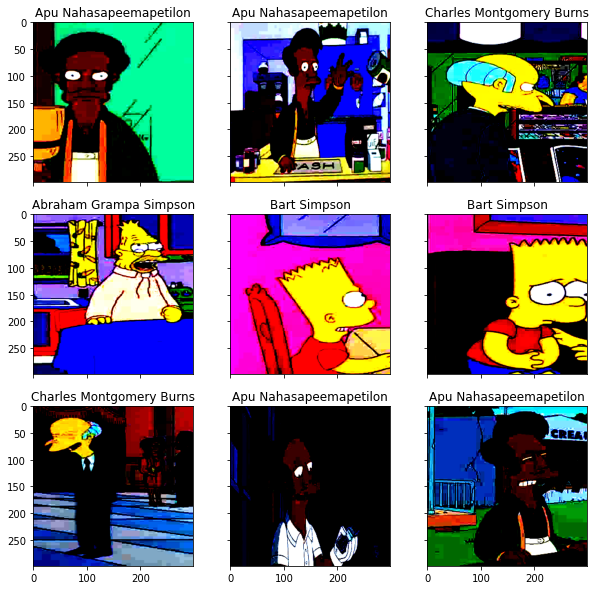

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(10, 10), 
                       sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(), 
                             val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), 
           title=img_label,plt_ax=fig_x)

Можете добавить ваши любимые сцены и классифицировать их. (веселые результаты можно кидать в чат)

### Функции тернировки(из ноутбука)

In [ ]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [ ]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [1]:
def train(train_files, val_files, model, epochs, batch_size):
    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters())
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history

In [ ]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [ ]:
classes = np.unique([path.parent.name for path in train_val_files])
n_classes = len(classes)

### Функции тренировок(из семинара)

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0
    
    #Ваш код здесь
    losses = {'train': [], "val": []}

    pbar = trange(num_epochs, desc="Epoch:")

    for epoch in pbar:
        # каждя эпоха имеет обучающую и тестовую стадии
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train(True)  # установаить модель в режим обучения
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            # итерируемся по батчам
            for data in tqdm(dataloaders[phase], leave=False, desc=f"{phase} iter:"):
                # получаем картинки и метки
                inputs, labels = data

                # оборачиваем в переменные
                inputs = inputs.to(DEVICE)
                labels = labels.to(DEVICE)


                # инициализируем градиенты параметров
                if phase=="train":
                    optimizer.zero_grad()

                # forward pass
                if phase == "eval":
                    with torch.no_grad():
                        outputs = model(inputs)
                else:
                    outputs = model(inputs)
                preds = torch.argmax(outputs, -1)
                loss = criterion(outputs, labels)

                # backward pass + оптимизируем только если это стадия обучения
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # статистика
                running_loss += loss.item()
                running_corrects += int(torch.sum(preds == labels.data))

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]
            
            # Ваш код здесь
            losses[phase].append(epoch_loss)
            
            pbar.set_description('{} Loss: {:.4f} Acc: {:.4f}'.format(
                                    phase, epoch_loss, epoch_acc
                                ))

            # если достиглось лучшее качество, то запомним веса модели
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # загрузим лучшие веса модели
    model.load_state_dict(best_model_wts)
    return model, losses

In [ ]:
def evaluate(model):
    model.eval()
    
    runninig_correct = 0
    for data in dataloaders['val']:
        # получаем картинки и метки
        inputs, labels = data
        
        # переносим на gpu, если возможно
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
            
        # forard pass
        output = model(inputs)
        _, predicted = torch.max(output, 1)
        
        runninig_correct += int(torch.sum(predicted == labels))
        
    return runninig_correct / dataset_sizes['val']

### VGG16

In [ ]:
model_vgg16 = models.vgg16(pretrained=True)
    
num_features = 25088

layers_to_unfreeze = 4

for param in model_vgg16.classifier[:-layers_to_unfreeze].parameters():
    param.requires_grad = False

model_vgg16.classifier = nn.Sequential(nn.Linear(num_features, 128),
                                 nn.Linear(128, n_classes))

model_vgg16 = model_vgg16.to(DEVICE)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


In [ ]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')
train_dataset = SimpsonsDataset(train_files, mode='train')

In [ ]:
history = train(train_dataset, val_dataset, model=model_vgg16, epochs=20, batch_size=128)


Epoch 001 train_loss: 3.0961     val_loss 2.6452 train_acc 0.1503 val_acc 0.2643

Epoch 002 train_loss: 1.9522     val_loss 1.6145 train_acc 0.4660 val_acc 0.5580

Epoch 003 train_loss: 1.3482     val_loss 1.2503 train_acc 0.6266 val_acc 0.6782

Epoch 004 train_loss: 0.8376     val_loss 0.8983 train_acc 0.7728 val_acc 0.7733

Epoch 005 train_loss: 0.5408     val_loss 0.7639 train_acc 0.8524 val_acc 0.8154

Epoch 006 train_loss: 0.3783     val_loss 0.7204 train_acc 0.8943 val_acc 0.8140

Epoch 007 train_loss: 0.2755     val_loss 0.7574 train_acc 0.9192 val_acc 0.8344

Epoch 008 train_loss: 0.2253     val_loss 0.7134 train_acc 0.9299 val_acc 0.8451

Epoch 009 train_loss: 0.2001     val_loss 0.8640 train_acc 0.9404 val_acc 0.8411

Epoch 010 train_loss: 0.1572     val_loss 0.7823 train_acc 0.9524 val_acc 0.8399

Epoch 011 train_loss: 0.1116     val_loss 0.9531 train_acc 0.9635 val_acc 0.8509

Epoch 012 train_loss: 0.1236     val_loss 0.8076 train_acc 0.9621 val_acc 0.8568

Epoch 013 train

In [ ]:
torch.save(model.state_dict(), 'gdrive/MyDrive/DataScience[Практика]/МФТИ[курс]/Second_task_Kaggle/VGG16_01.pth')

In [ ]:
model = model_vgg16

### VGG19

In [ ]:
model_vgg19 = models.vgg19(pretrained=True)
    
num_features = 25088

layers_to_unfreeze = 3

for param in model_vgg19.classifier[:-layers_to_unfreeze].parameters():
    param.requires_grad = False

model_vgg19.classifier = nn.Linear(25088, n_classes)

model_vgg19 = model_vgg19.to(DEVICE)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


In [ ]:
torch.cuda.empty_cache()
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')
    
train_dataset = SimpsonsDataset(train_files, mode='train')

In [ ]:
torch.cuda.empty_cache()

In [ ]:
history_vgg19 = train(train_dataset, val_dataset, model=model_vgg19, epochs=5, batch_size=256)

RuntimeError: ignored

### Inception_3

In [ ]:
torch.cuda.empty_cache()

In [ ]:
model_inception3 = models.inception_v3(pretrained=True)

for param in model_inception3.parameters():
  param.requires_grad = False

model_inception3.AuxLogits.fc = nn.Linear(768, n_classes)
model_inception3.fc = nn.Linear(2048, n_classes)

In [ ]:
model_inception3.classifier = nn.Linear(25088, n_classes)

model_inception3 = model_inception3.to(DEVICE)

loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model_inception3.parameters(), lr=1e-4)

exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [ ]:
%%time
model_inception3.aux_logits = False
model_inception3, losses = train_model(model_inception3, loss_fn, optimizer, exp_lr_scheduler, num_epochs=25)

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)



Training complete in 111m 28s
Best val Acc: 0.620362
CPU times: user 1h 50min 23s, sys: 1min 36s, total: 1h 52min
Wall time: 1h 51min 27s


In [ ]:
torch.save(model_inception3.state_dict(), 'gdrive/MyDrive/DataScience[Практика]/МФТИ[курс]/Second_task_Kaggle/Inception3.pth')

### Построение Loss и Accuracy графиков

In [ ]:
loss, acc, val_loss, val_acc = zip(*history)

NameError: ignored

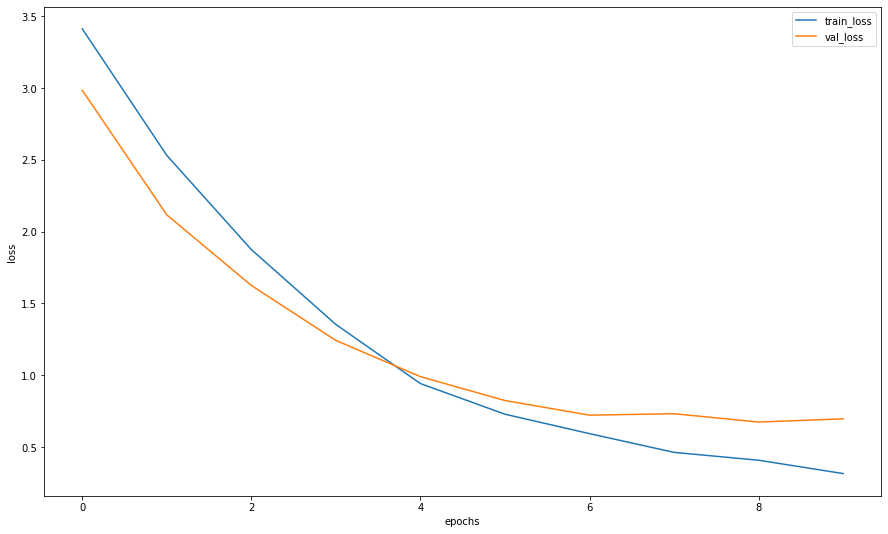

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

### Ну и что теперь со всем этим делать?

In [ ]:
best_model = models.vgg16(pretrained=False)
best_model.classifier = nn.Sequential(nn.Linear(25088, 128),
                                 nn.Linear(128, n_classes))
best_model.load_state_dict(torch.load('gdrive/MyDrive/DataScience[Практика]/МФТИ[курс]/Second_task_Kaggle/VGG16_01.pth'))
best_model.to(DEVICE)

In [ ]:
best_model = model_inception3

In [ ]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [ ]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(best_model, ex_img.unsqueeze(0))

In [ ]:
idxs = list(map(int, range(1000)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(best_model, imgs)

In [ ]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [ ]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [i for i in y_pred]

In [ ]:
f1_score(actual_labels, preds_class, average='micro')


0.636

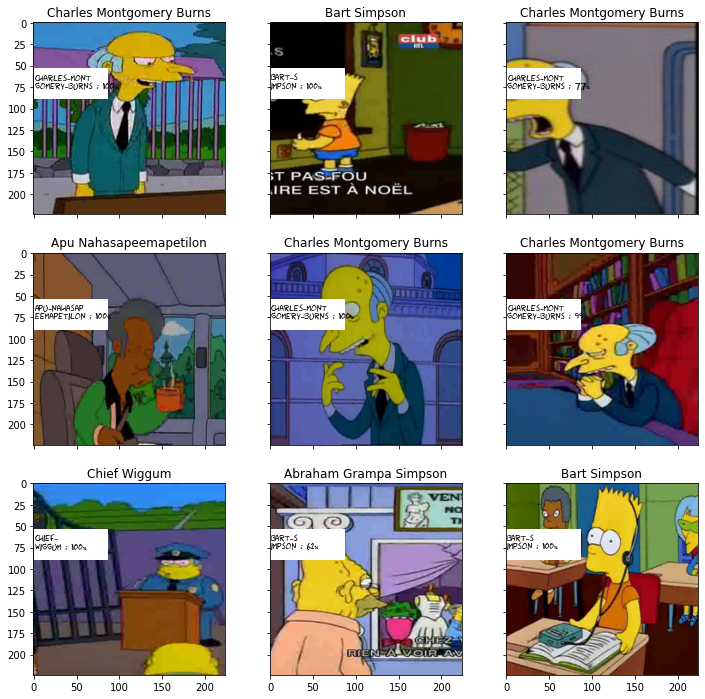

In [ ]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(best_model, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

Попробуйте найти те классы, которые сеть не смогла расспознать. Изучите данную проблему, это понадобится в дальнейшем.

### Submit на Kaggle

In [ ]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(best_model, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

In [ ]:
import pandas as pd
my_submit = pd.read_csv("gdrive/MyDrive/DataScience[Практика]/МФТИ[курс]/Second_task_Kaggle/data/sample_submission.csv")
_my_submit = pd.DataFrame({'Image_id': test_filenames, 'Expected': preds})
my_submit['Id'] = _my_submit['Image_id']
my_submit['Expected'] = _my_submit['Expected']

In [ ]:
my_submit.to_csv('gdrive/MyDrive/DataScience[Практика]/МФТИ[курс]/Second_task_Kaggle/vgg_baseline.csv', index=False)